In [81]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install kaggle

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2024-10-08 19:30:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-08 19:30:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-08 19:30:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [60]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [61]:
!pip isntall transformers

ERROR: unknown command "isntall" - maybe you meant "install"


In [28]:

!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


*Import necessary dependancies*

In [77]:


import os
import json
import numpy as np
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM, Bidirectional, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import keras_tuner as kt
from transformers import BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import re






Data collection - Kaggle API


In [11]:
kaggle_dictionary = json.load(open('/content/kaggle.json'))


In [12]:
# setup kaggle credentials as environment variables

os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]


In [14]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
!ls

imdb-dataset-of-50k-movie-reviews.zip  kaggle.json  sample_data


In [16]:
#unzip dataset
with ZipFile('/content/imdb-dataset-of-50k-movie-reviews.zip','r') as zipObj:
  zipObj.extractall()

In [17]:
!ls

'IMDB Dataset.csv'   imdb-dataset-of-50k-movie-reviews.zip   kaggle.json   sample_data


**Now we can Load the Dataset**

In [63]:
data = pd.read_csv('/content/IMDB Dataset.csv')

In [10]:
data.shape

(50000, 2)

In [11]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [64]:
data["sentiment"].value_counts()  # we can make sure if the data is balanced.

,count
sentiment,
positive,25000
negative,25000


In [65]:
data.replace({"sentiment": {"positive" : 1, "negative" : 0}}, inplace = True)

<ipython-input-65-b4f9de3e1e50>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"sentiment": {"positive" : 1, "negative" : 0}}, inplace = True)


In [14]:
data.head()
data["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


In [66]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-letter characters
    text = text.lower()  # Convert to lowercase
    return text  # No stopword removal

data['review'] = data['review'].apply(preprocess_text)

In [67]:
# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

***It's time to Preprocess!***

In [68]:
# Tokenize text data
max_words = 10000  # Only keep top 5000 most common words
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data["review"])

# Convert reviews to sequences and pad them to the same length
maxlen = 200
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=maxlen)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=maxlen)

In [17]:
print(X_train)

[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [18]:
print(X_test)

[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


In [69]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [20]:
print(Y_train)

39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64


In [21]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")  #make input dimension same

Vocabulary size: 112280


In [70]:
# Load pre-trained GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim, word_index, max_words):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100  # GloVe's vector dimension
word_index = tokenizer.word_index
glove_path = '/content/glove.6B.100d.txt'  # Update with the correct path to GloVe file
embedding_matrix = load_glove_embeddings(glove_path, embedding_dim, word_index, max_words)

In [75]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W))  # Use tf.tanh and tf.matmul
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Embedding Layer with pre-trained GloVe embeddings
    model.add(Embedding(input_dim=max_words,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=maxlen,
                        trainable=False))

    # LSTM layer with hyperparameter tuning
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),
                                 return_sequences=True,
                                 dropout=0.2, recurrent_dropout=0.2)))

    # Attention Layer
    model.add(AttentionLayer())

    # Dense layers
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up Keras Tuner for hyperparameter tuning
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=3,
                        directory='my_dir',
                        project_name='sentiment_analysis')

# Run the hyperparameter search
tuner.search(X_train, Y_train, epochs=5, validation_split=0.2)

In [79]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hp)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Let us now train the model**


In [80]:
# Train the model with the best hyperparameters
history = best_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 259s 511ms/step - accuracy: 0.6470 - loss: 0.6187 - val_accuracy: 0.8290 - val_loss: 0.3900
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 278s 543ms/step - accuracy: 0.8150 - loss: 0.4103 - val_accuracy: 0.8510 - val_loss: 0.3484
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 295s 488ms/step - accuracy: 0.8408 - loss: 0.3688 - val_accuracy: 0.8679 - val_loss: 0.3099
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 488ms/step - accuracy: 0.8498 - loss: 0.3431 - val_accuracy: 0.8760 - val_loss: 0.2984
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 283s 530ms/step - accuracy: 0.8628 - loss: 0.3246 - val_accuracy: 0.8817 - val_loss: 0.2834


In [83]:
# Save the model in the new Keras format
best_model.save('/content/drive/MyDrive/best_sentiment_model.keras')


**Evaluate the model**

In [84]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - accuracy: 0.8771 - loss: 0.2856
Test Loss: 0.2855043113231659
Test Accuracy: 0.878600001335144


313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step


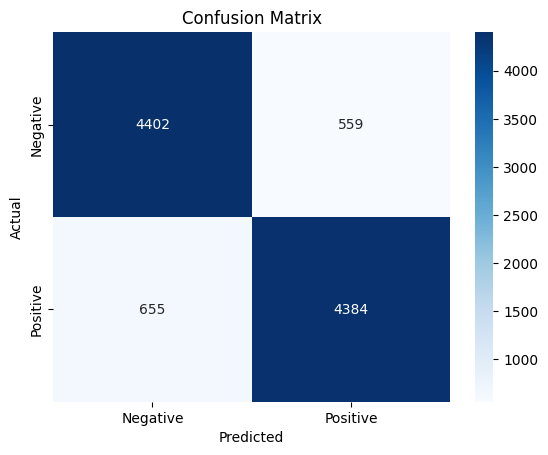

In [85]:
# Confusion Matrix
predictions = (best_model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(Y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

In [86]:
#classification report
print("Classification Report: ")
print(classification_report(Y_test, predictions))

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4961
           1       0.89      0.87      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



*Let us take this further and build a predictive system*

In [87]:
# Prediction function
def sentiment_prediction(review):
    review = preprocess_text(review)  # Preprocess the input review
    sequence = tokenizer.texts_to_sequences([review])  # Tokenize and pad
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)

    prediction = best_model.predict(padded_sequence)
    sentiment = "positive" if prediction[0][0] > 0.4 else "negative"  # Lower the threshold to 0.4 to make it more lenient towards positive/neutral reviews

    return sentiment

In [94]:
#test cases

review1 = "This movie is amazing."
sentiment1 = sentiment_prediction(review1)
print(f"Review: {review1}\nSentiment: {sentiment1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
Review: L
Sentiment: positive


In [89]:
review2 = "This movie is terrible. I hate it."
sentiment2 = sentiment_prediction(review2)
print(f"Review: {review2}\nSentiment: {sentiment2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Review: This movie is terrible. I hate it.
Sentiment: negative


In [90]:
review3 = "I would watch this movie again."
sentiment3 = sentiment_prediction(review3)
print(f"Review: {review3}\nSentiment: {sentiment3}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Review: I would watch this movie again.
Sentiment: positive


In [1]:
'''Generate requirements.txt if required'''

##!pip freeze > requirements.txt